# Insertion analysis — replicate similarity with sgRNA highlighting

This notebook compares replicate TSVs (per-read insertion calls) and highlights the **sgRNA binding site** on insertion plots.

**Outputs**
- Genome-wide insertion density plots (per replicate; binned, log y; per-chrom stacked)
- Target-window insertion histogram (per replicate; relative to cut site) with sgRNA region highlighted
- Top hotspot tables (per replicate + union across replicates)
- Strand bias summary (global + target window)
- Replicate similarity metrics (genome-wide binned Pearson/Spearman + target-window correlation)

> TSV columns required: `ref`, `ins0`, `strand`, `mapq`


In [1]:
# --- User configuration ---

from pathlib import Path

# Replicate TSVs (each input is a file path to a TSV file)
TSVS = [
     ("rep1_Wallace4_R1_sgRNA3_filtered", Path("/Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/filtered_A13_S19_L001_R1_001.insertions.5p.tsv")),
     ("rep2_Wallace4_R1_sgRNA3_filtered", Path("/Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/filtered_A14_S20_L001_R1_001.insertions.5p.tsv")),
]

MAPQ_MIN = 30

# Genome FASTA used to locate the sgRNA binding site.
# - If FASTA has multiple records, it should contain records whose IDs match the TSV `ref` column.
# - If FASTA has a single record, set TARGET_REF below to the TSV ref name and it will be used.
GENOME_FASTA = Path("/Users/ecreed/Desktop/KelloggRotation/CodeProjects/cJP003_assembly.fasta")

# sgRNA protospacer sequence in DNA alphabet (A/C/G/T), no PAM
SGRNA = "TCTGACAGCAGACGTGCACTGGCC"  # e.g., "GTTTT...20nt..."

# Target-window settings (for on-target histograms/similarity)
TARGET_REF = None   # e.g., "chr1" (must match TSV `ref`)
CUT_SITE_0 = None   # 0-based coordinate on TARGET_REF
WINDOW_BP = 500     # +/- around cut site

# Genome-wide binning
BIN_SIZE_BP = 100

# Hotspots
TOP_N_HOTSPOTS = 20

# Plot controls
SHOW_PER_CHROM_SUBPLOTS = True
MAX_CHROMS_TO_PLOT = 30

# OUTPUT FOLDER - specify where to save all results
OUTPUT_FOLDER = Path("/Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
print(f"Output folder: {OUTPUT_FOLDER.absolute()}")


Output folder: /Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

def _require(condition: bool, msg: str):
    if not condition:
        raise ValueError(msg)

_require(len(TSVS) >= 2, "Add at least two TSVs to `TSVS` (replicates) before running.")
for label, path in TSVS:
    _require(Path(path).exists(), f"File not found: {path}")

if GENOME_FASTA is not None:
    _require(Path(GENOME_FASTA).exists(), f"FASTA not found: {GENOME_FASTA}")

print(f"Loaded {len(TSVS)} TSV paths.")


Loaded 2 TSV paths.


In [3]:
# Load helper functions (adapted from your pipeline)
# - postprocessHelpers.py provides FASTA loading + sgRNA->genome mapping

import importlib.util, sys

def load_module_from_path(name: str, path: str):
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod
    spec.loader.exec_module(mod)
    return mod

hp = load_module_from_path("postprocessHelpers", "postprocessHelpers.py")


In [4]:
def load_tsv(label: str, path: Path, mapq_min: int = 30) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t")
    needed = {"ref", "ins0", "strand", "mapq"}
    missing = needed - set(df.columns)
    _require(len(missing) == 0, f"{label}: missing columns {missing}. Found: {list(df.columns)}")

    df = df.copy()
    df["ins0"] = pd.to_numeric(df["ins0"], errors="coerce")
    df["mapq"] = pd.to_numeric(df["mapq"], errors="coerce")
    df = df.dropna(subset=["ref", "ins0", "strand", "mapq"])
    df = df[df["mapq"] >= mapq_min]
    df["ins0"] = df["ins0"].astype(int)
    df["strand"] = df["strand"].astype(str)
    return df

dfs = {}
for label, path in TSVS:
    df = load_tsv(label, Path(path), MAPQ_MIN)
    dfs[label] = df
    print(f"{label}: {len(df):,} insertions after MAPQ>={MAPQ_MIN}")


rep1_Wallace4_R1_sgRNA3_filtered: 1,814 insertions after MAPQ>=30
rep2_Wallace4_R1_sgRNA3_filtered: 550 insertions after MAPQ>=30


In [5]:
# Quick QC table
qc = []
for label, df in dfs.items():
    qc.append({
        "sample": label,
        "insertions": len(df),
        "refs": df["ref"].nunique(),
        "+ strand": int((df["strand"] == "+").sum()),
        "- strand": int((df["strand"] == "-").sum()),
        "other strand": int((~df["strand"].isin(["+","-"])).sum()),
    })
pd.DataFrame(qc).sort_values("sample")


,sample,insertions,refs,+ strand,- strand,other strand
0,rep1_Wallace4_R1_sgRNA3_filtered,1814,1,695,1119,0
1,rep2_Wallace4_R1_sgRNA3_filtered,550,1,207,343,0


In [6]:
# Load reference sequences for sgRNA highlighting
# Expects GENOME_FASTA record IDs to match TSV refs (df['ref']).
# If GENOME_FASTA has a single record, it will be used as DEFAULT_SEQ.

ref_seqs = None
default_seq = None

if GENOME_FASTA is not None:
    ref_seqs = hp.load_fasta_as_dict(str(GENOME_FASTA))
    if len(ref_seqs) == 1:
        default_seq = next(iter(ref_seqs.values()))
        print("Loaded 1 FASTA record (default_seq).")
    else:
        print(f"Loaded {len(ref_seqs)} FASTA records.")
else:
    print("GENOME_FASTA is not set: sgRNA binding site will not be highlighted.")

def get_ref_sequence(ref_name: str) -> str | None:
    if ref_seqs is None:
        return None
    if ref_name in ref_seqs:
        return ref_seqs[ref_name]
    if default_seq is not None:
        return default_seq
    return None


Loaded 1 FASTA record (default_seq).


In [7]:
# sgRNA mapping helper (drawn from analyze_all: map guide -> genome, then highlight with axvspan)

def sgrna_hit_for_ref(ref_name: str) -> dict | None:
    if SGRNA is None or GENOME_FASTA is None:
        return None
    seq = get_ref_sequence(ref_name)
    if seq is None:
        return None
    hits = hp.map_guide_to_genome(SGRNA, seq)
    if not hits:
        return None
    # If multiple hits, pick the first; you can change this selection logic if needed.
    return hits[0]

def _draw_sgrna_highlight(ax, hit: dict, label_prefix: str = "sgRNA"):
    ax.axvspan(hit["start"], hit["end"], alpha=0.3, label=f"{label_prefix} ({hit['strand']})")
    # arrow at start (style similar to analyze_all)
    ax.annotate(
        "",
        xy=(hit["start"], 0),
        xytext=(hit["start"], -0.05),
        arrowprops=dict(arrowstyle="->", color="red", linewidth=2),
        annotation_clip=False,
    )


Saved: /Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/genomewide_density_rep1_Wallace4_R1_sgRNA3_filtered.png


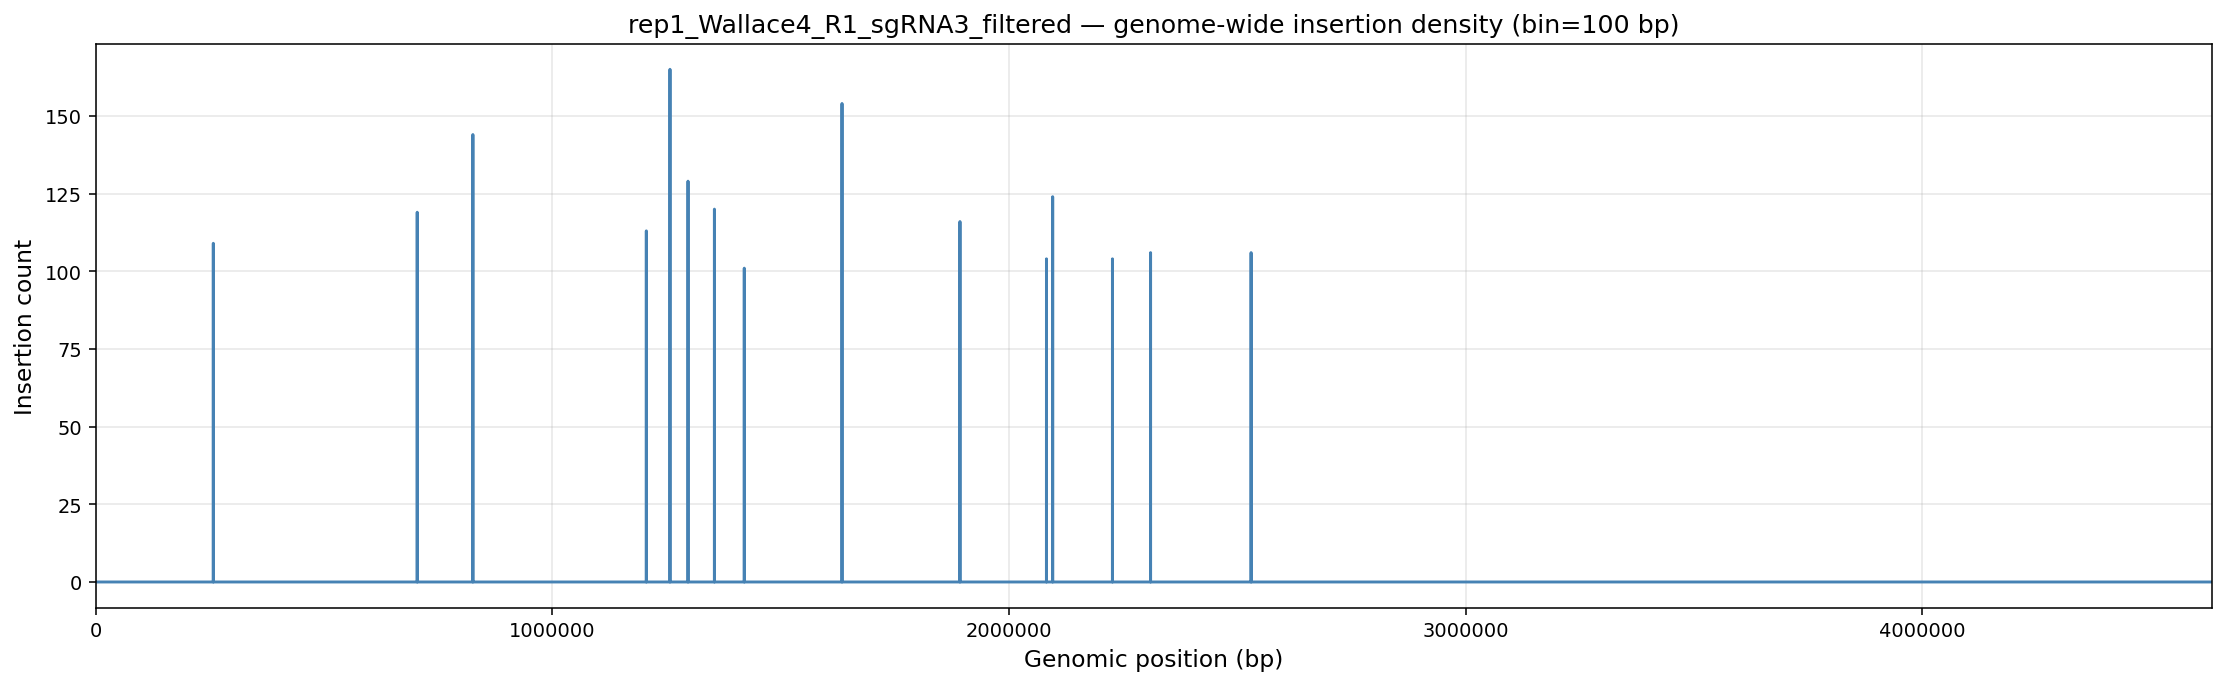

Saved: /Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/genomewide_density_rep2_Wallace4_R1_sgRNA3_filtered.png


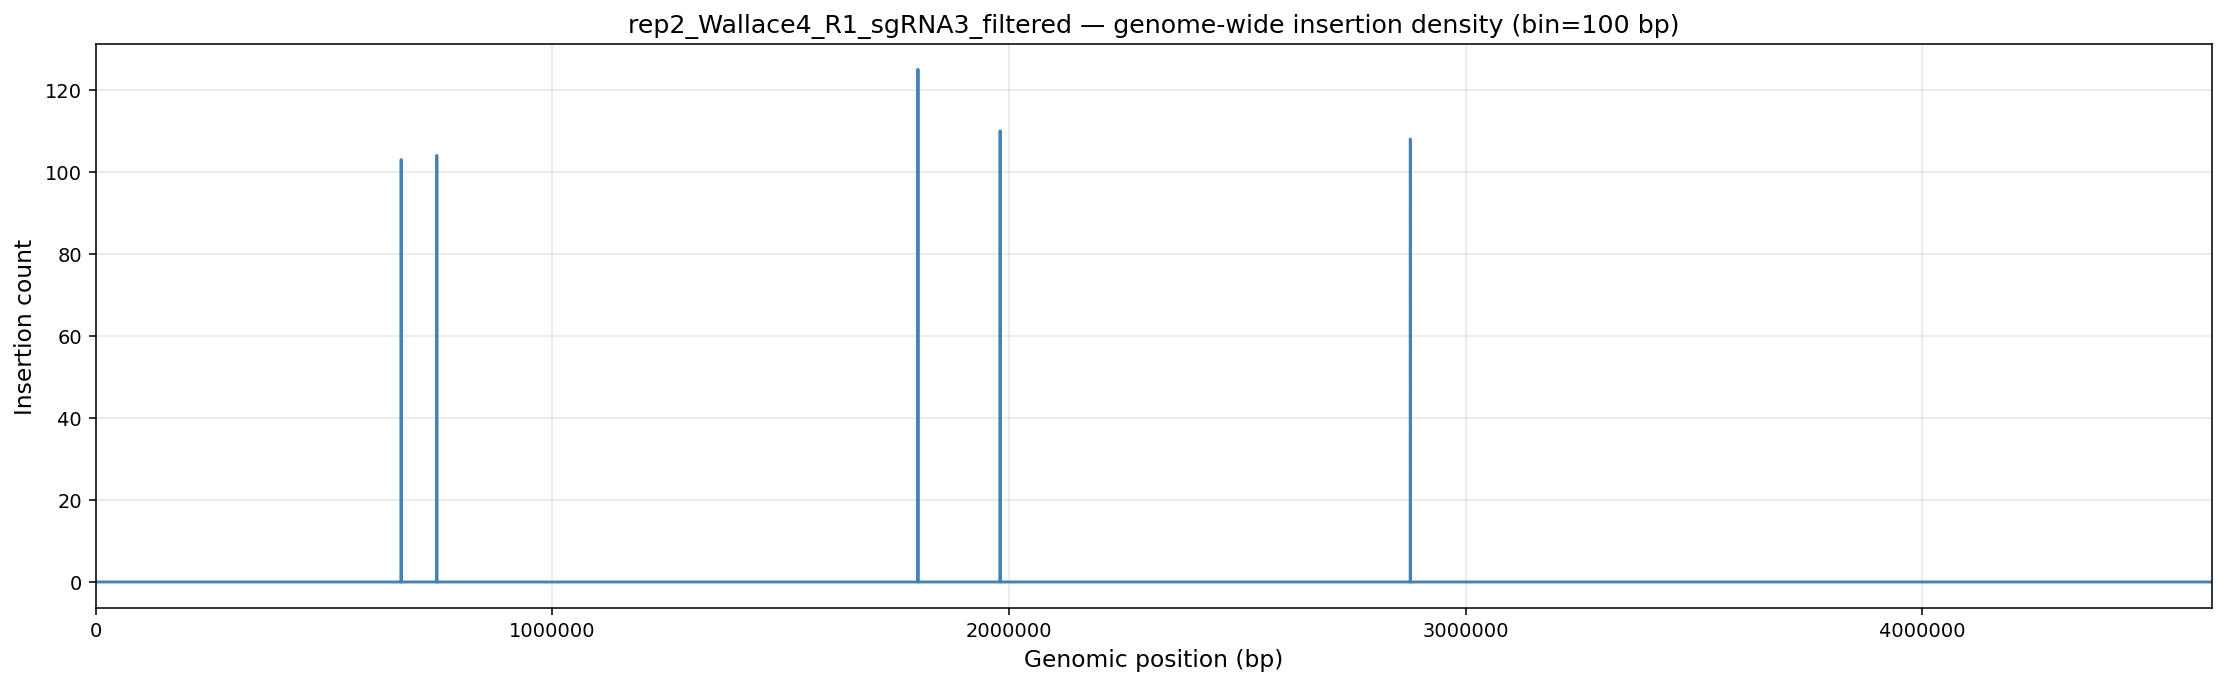

In [8]:
def genomewide_density_plots(dfs: dict, bin_size: int = 1000,
                             output_folder: Path = None):
    # For each sample, plot genome-wide insertion density across all chromosomes pooled.
    for sample, df in dfs.items():
        fig, ax = plt.subplots(figsize=(16, 5))
        
        # Pool all insertions across all chromosomes
        all_insertions = df["ins0"].values
        
        # Get genome length from reference sequence
        if default_seq is not None:
            genome_length = len(default_seq)
        else:
            # If no default sequence, use max coordinate from data
            genome_length = all_insertions.max()
        
        # Create bins across the full genome
        min_coord = 0
        max_coord = genome_length
        bins = np.arange(min_coord, max_coord + bin_size, bin_size)
        
        if len(bins) < 2:
            print(f"Skipping {sample}: insufficient data")
            continue
        
        counts, edges = np.histogram(all_insertions, bins=bins)
        mids = (edges[:-1] + edges[1:]) / 2
        
        ax.plot(mids, counts, linewidth=1.5, color='steelblue')
        ax.set_xlabel("Genomic position (bp)", fontsize=12)
        ax.set_ylabel("Insertion count", fontsize=12)
        ax.set_title(f"{sample} — genome-wide insertion density (bin={bin_size} bp)", fontsize=13)
        ax.grid(True, alpha=0.3, axis="both")
        ax.set_xlim(min_coord, max_coord)
        ax.set_yscale('linear')  # Explicitly set to linear scale
        
        # Format x-axis to show bp values
        ax.ticklabel_format(style='plain', axis='x')
        
        plt.tight_layout()
        
        if output_folder:
            fig_path = output_folder / f"genomewide_density_{sample}.png"
            fig.savefig(fig_path, dpi=150, bbox_inches='tight')
            print(f"Saved: {fig_path}")
        
        plt.show()

genomewide_density_plots(
    dfs,
    bin_size=BIN_SIZE_BP,
    output_folder=OUTPUT_FOLDER,
)

In [9]:
# def genomewide_density_overlay(dfs: dict, bin_size: int = 1000,
#                                output_folder: Path = None):
#     """Plot individual density plots followed by overlay of all replicates on a single figure."""
    
#     # Define colorblind-friendly colors: orange and blue
#     colors = ['#E69F00', '#0072B2']  # orange, blue (from colorblind-safe palette)
    
#     # Get genome length from reference sequence
#     if default_seq is not None:
#         genome_length = len(default_seq)
#     else:
#         # If no default sequence, use max coordinate across all samples
#         genome_length = max(df["ins0"].max() for df in dfs.values())
    
#     # Create bins across the full genome
#     min_coord = 0
#     max_coord = genome_length
#     bins = np.arange(min_coord, max_coord + bin_size, bin_size)
    
#     if len(bins) < 2:
#         print("Insufficient data for binning")
#         return
    
#     # First, plot individual replicates with their assigned colors
#     for idx, (sample, df) in enumerate(dfs.items()):
#         fig, ax = plt.subplots(figsize=(16, 5))
        
#         all_insertions = df["ins0"].values
#         counts, edges = np.histogram(all_insertions, bins=bins)
#         mids = (edges[:-1] + edges[1:]) / 2
        
#         # Use the same color as will be used in overlay
#         color = colors[idx % len(colors)]
#         ax.plot(mids, counts, linewidth=2.5, color=color, label=sample)
        
#         ax.set_xlabel("Genomic position (bp)", fontsize=12)
#         ax.set_ylabel("Insertion count", fontsize=12)
#         ax.set_title(f"{sample} — genome-wide insertion density (bin={bin_size} bp)", fontsize=13)
#         ax.grid(True, alpha=0.3, axis="both")
#         ax.set_xlim(min_coord, max_coord)
#         ax.set_yscale('linear')
#         ax.ticklabel_format(style='plain', axis='x')
#         ax.legend(loc='upper right')
        
#         plt.tight_layout()
        
#         if output_folder:
#             fig_path = output_folder / f"genomewide_density_overlay_{sample}.png"
#             fig.savefig(fig_path, dpi=150, bbox_inches='tight')
#             print(f"Saved: {fig_path}")
        
#         plt.show()
    
#     # Now create the overlay plot
#     fig, ax = plt.subplots(figsize=(16, 5))
    
#     # Plot each replicate as LINE with transparency
#     for idx, (sample, df) in enumerate(dfs.items()):
#         all_insertions = df["ins0"].values
#         counts, edges = np.histogram(all_insertions, bins=bins)
#         mids = (edges[:-1] + edges[1:]) / 2
        
#         # Use line plot with transparency for overlay effect
#         color = colors[idx % len(colors)]
#         ax.plot(mids, counts, linewidth=2.5, color=color, label=sample, alpha=0.6)
    
#     ax.set_xlabel("Genomic position (bp)", fontsize=12)
#     ax.set_ylabel("Insertion count", fontsize=12)
#     ax.set_title(f"Genome-wide insertion density overlay (bin={bin_size} bp)", fontsize=13)
#     ax.grid(True, alpha=0.3, axis="both")
#     ax.set_xlim(min_coord, max_coord)
#     ax.set_yscale('linear')
#     ax.ticklabel_format(style='plain', axis='x')
#     ax.legend(loc='upper right')
    
#     plt.tight_layout()
    
#     if output_folder:
#         fig_path = output_folder / f"genomewide_density_overlay_combined.png"
#         fig.savefig(fig_path, dpi=150, bbox_inches='tight')
#         print(f"Saved: {fig_path}")
    
#     plt.show()

# # Call the overlay function
# genomewide_density_overlay(
#     dfs,
#     bin_size=BIN_SIZE_BP,
#     output_folder=OUTPUT_FOLDER,
# )

Saved: /Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/genomewide_density_combined.png


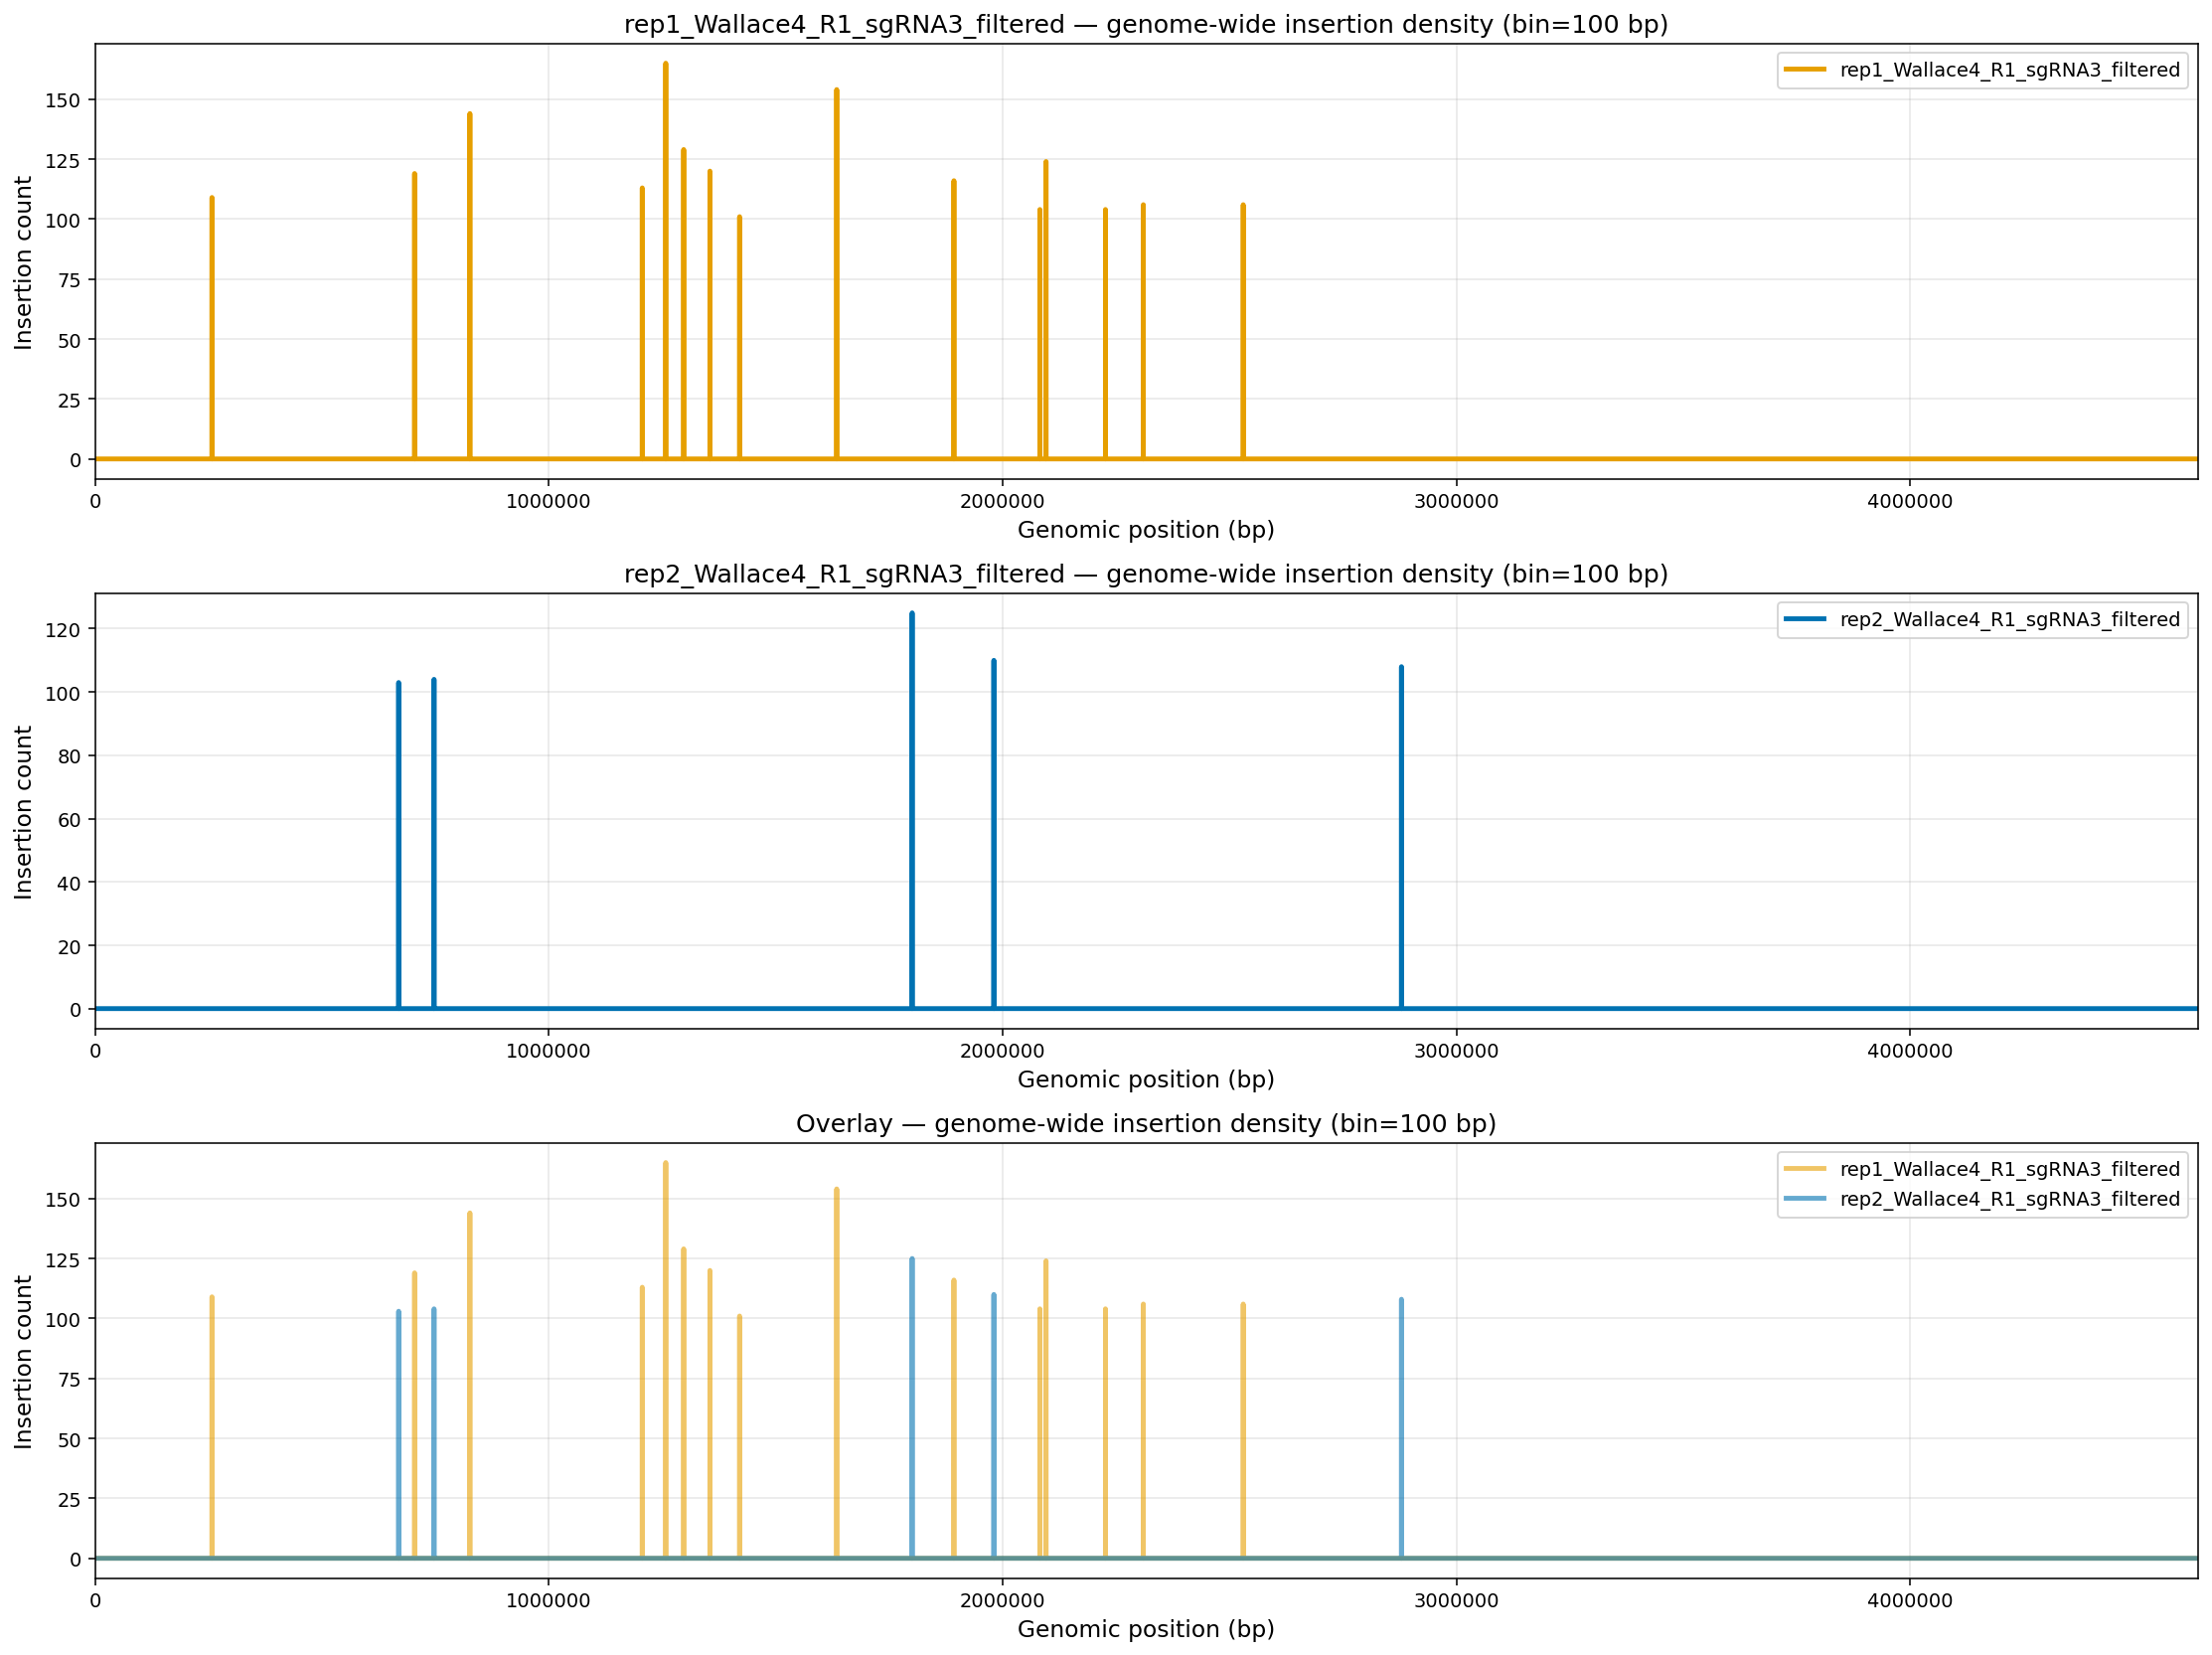

In [10]:
def genomewide_density_overlay(dfs: dict, bin_size: int = 1000,
                               output_folder: Path = None):
    """Plot individual density plots and overlay on a single figure with subplots."""
    
    # Define colorblind-friendly colors: orange and blue
    colors = ['#E69F00', '#0072B2']  # orange, blue (from colorblind-safe palette)
    
    # Get genome length from reference sequence
    if default_seq is not None:
        genome_length = len(default_seq)
    else:
        # If no default sequence, use max coordinate across all samples
        genome_length = max(df["ins0"].max() for df in dfs.values())
    
    # Create bins across the full genome
    min_coord = 0
    max_coord = genome_length
    bins = np.arange(min_coord, max_coord + bin_size, bin_size)
    
    if len(bins) < 2:
        print("Insufficient data for binning")
        return
    
    # Create figure with 3 subplots (2 individual + 1 overlay)
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot individual replicates on first two subplots
    for idx, (sample, df) in enumerate(dfs.items()):
        ax = axes[idx]
        
        all_insertions = df["ins0"].values
        counts, edges = np.histogram(all_insertions, bins=bins)
        mids = (edges[:-1] + edges[1:]) / 2
        
        # Use the same color as will be used in overlay
        color = colors[idx % len(colors)]
        ax.plot(mids, counts, linewidth=2.5, color=color, label=sample)
        
        ax.set_xlabel("Genomic position (bp)", fontsize=12)
        ax.set_ylabel("Insertion count", fontsize=12)
        ax.set_title(f"{sample} — genome-wide insertion density (bin={bin_size} bp)", fontsize=13)
        ax.grid(True, alpha=0.3, axis="both")
        ax.set_xlim(min_coord, max_coord)
        ax.set_yscale('linear')
        ax.ticklabel_format(style='plain', axis='x')
        ax.legend(loc='upper right')
    
    # Create the overlay plot on the third subplot
    ax = axes[2]
    
    # Plot each replicate as LINE with transparency
    for idx, (sample, df) in enumerate(dfs.items()):
        all_insertions = df["ins0"].values
        counts, edges = np.histogram(all_insertions, bins=bins)
        mids = (edges[:-1] + edges[1:]) / 2
        
        # Use line plot with transparency for overlay effect
        color = colors[idx % len(colors)]
        ax.plot(mids, counts, linewidth=2.5, color=color, label=sample, alpha=0.6)
    
    ax.set_xlabel("Genomic position (bp)", fontsize=12)
    ax.set_ylabel("Insertion count", fontsize=12)
    ax.set_title(f"Overlay — genome-wide insertion density (bin={bin_size} bp)", fontsize=13)
    ax.grid(True, alpha=0.3, axis="both")
    ax.set_xlim(min_coord, max_coord)
    ax.set_yscale('linear')
    ax.ticklabel_format(style='plain', axis='x')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    if output_folder:
        fig_path = output_folder / f"genomewide_density_combined.png"
        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {fig_path}")
    
    plt.show()

# Call the overlay function
genomewide_density_overlay(
    dfs,
    bin_size=BIN_SIZE_BP,
    output_folder=OUTPUT_FOLDER,
)

In [11]:
# def genomewide_density_overlay(dfs: dict, bin_size: int = 1000,
#                                output_folder: Path = None):
#     """Overlay density plots from all replicates on a single figure."""
    
#     fig, ax = plt.subplots(figsize=(16, 5))
    
#      # Define high-contrast blue palette colors
#     colors = ['#00008B', '#1E90FF', '#000080', '#4682B4', '#191970', '#6495ED']  
#     # darkblue, dodgerblue, navy, steelblue, midnightblue, cornflowerblue
    
#     # Get genome length from reference sequence
#     if default_seq is not None:
#         genome_length = len(default_seq)
#     else:
#         # If no default sequence, use max coordinate across all samples
#         genome_length = max(df["ins0"].max() for df in dfs.values())
    
#     # Create bins across the full genome
#     min_coord = 0
#     max_coord = genome_length
#     bins = np.arange(min_coord, max_coord + bin_size, bin_size)
    
#     if len(bins) < 2:
#         print("Insufficient data for binning")
#         return
    
#     # Plot each replicate as LINE (matching the individual plots)
#     for idx, (sample, df) in enumerate(dfs.items()):
#         all_insertions = df["ins0"].values
#         counts, edges = np.histogram(all_insertions, bins=bins)
#         mids = (edges[:-1] + edges[1:]) / 2
        
#         # Use line plot with darker colors and thicker lines
#         color = colors[idx % len(colors)]
#         ax.plot(mids, counts, linewidth=2.5, color=color, label=sample, alpha=0.8)
    
#     ax.set_xlabel("Genomic position (bp)", fontsize=12)
#     ax.set_ylabel("Insertion count", fontsize=12)
#     ax.set_title(f"Genome-wide insertion density overlay (bin={bin_size} bp)", fontsize=13)
#     ax.grid(True, alpha=0.3, axis="both")
#     ax.set_xlim(min_coord, max_coord)
#     ax.set_yscale('linear')
#     ax.ticklabel_format(style='plain', axis='x')
#     ax.legend(loc='upper right')
    
#     plt.tight_layout()
    
#     if output_folder:
#         fig_path = output_folder / f"genomewide_density_overlay.png"
#         fig.savefig(fig_path, dpi=150, bbox_inches='tight')
#         print(f"Saved: {fig_path}")
    
#     plt.show()

# # Call the overlay function
# genomewide_density_overlay(
#     dfs,
#     bin_size=BIN_SIZE_BP,
#     output_folder=OUTPUT_FOLDER,
# )

In [12]:
def top_hotspots(df: pd.DataFrame, n: int = 20) -> pd.DataFrame:
    counts = (
        df.groupby(["ref","ins0"])
          .size()
          .reset_index(name="count")
          .sort_values("count", ascending=False)
          .head(n)
    )
    counts["frequency_over_reads"] = counts["count"] / max(1, len(df))
    return counts

hotspot_tables = {}
for sample, df in dfs.items():
    ht = top_hotspots(df, TOP_N_HOTSPOTS)
    ht.insert(0, "sample", sample)
    hotspot_tables[sample] = ht

hotspots_all = pd.concat(hotspot_tables.values(), ignore_index=True)
hotspots_all

# Export individual hotspot tables to CSV
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for sample, ht in hotspot_tables.items():
    csv_path = OUTPUT_FOLDER / f"hotspots_{sample}_{timestamp}.csv"
    ht.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")


Saved: /Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/hotspots_rep1_Wallace4_R1_sgRNA3_filtered_20260130_132836.csv
Saved: /Users/ecreed/Desktop/KelloggRotation/CodeProjects/TagmentationAnalysis/01302026_output/test/hotspots_rep2_Wallace4_R1_sgRNA3_filtered_20260130_132836.csv


In [13]:
# Union of top sites across replicates, with per-sample counts and frequencies
union_sites = hotspots_all[["ref","ins0"]].drop_duplicates()

def counts_for_sites(df: pd.DataFrame, sites: pd.DataFrame) -> pd.DataFrame:
    c = df.groupby(["ref","ins0"]).size().reset_index(name="count")
    merged = sites.merge(c, on=["ref","ins0"], how="left").fillna({"count": 0})
    merged["count"] = merged["count"].astype(int)
    merged["frequency_over_reads"] = merged["count"] / max(1, len(df))
    return merged

wide = union_sites.copy()
for sample, df in dfs.items():
    m = counts_for_sites(df, union_sites)[["ref","ins0","count","frequency_over_reads"]].copy()
    m = m.rename(columns={"count": f"{sample}_count", "frequency_over_reads": f"{sample}_freq"})
    wide = wide.merge(m, on=["ref","ins0"], how="left")

count_cols = [c for c in wide.columns if c.endswith("_count")]
wide["total_count"] = wide[count_cols].sum(axis=1)
wide.sort_values("total_count", ascending=False).head(50)


,ref,ins0,rep1_Wallace4_R1_sgRNA3_filtered_count,rep1_Wallace4_R1_sgRNA3_filtered_freq,rep2_Wallace4_R1_sgRNA3_filtered_count,rep2_Wallace4_R1_sgRNA3_filtered_freq,total_count
0,contig_1,1257984,165,0.090959,0,0.000000,165
1,contig_1,1634641,154,0.084895,0,0.000000,154
2,contig_1,826391,144,0.079383,0,0.000000,144
3,contig_1,1297444,129,0.071114,0,0.000000,129
15,contig_1,1800927,0,0.000000,125,0.227273,125
4,contig_1,2095970,124,0.068357,0,0.000000,124
5,contig_1,1355210,120,0.066152,0,0.000000,120
6,contig_1,704415,119,0.065601,0,0.000000,119
7,contig_1,1892980,116,0.063947,0,0.000000,116
8,contig_1,1206181,113,0.062293,0,0.000000,113


In [14]:
def strand_bias_summary(df: pd.DataFrame) -> dict:
    plus = int((df["strand"] == "+").sum())
    minus = int((df["strand"] == "-").sum())
    other = int((~df["strand"].isin(["+","-"])).sum())
    total = len(df)
    return {
        "insertions": total,
        "+": plus, "-": minus, "other": other,
        "+ fraction": plus / total if total else np.nan,
        "- fraction": minus / total if total else np.nan,
        "+/- ratio": (plus / minus) if minus else (np.inf if plus else np.nan),
    }

strand_rows = []
for sample, df in dfs.items():
    d = strand_bias_summary(df)
    d["sample"] = sample
    strand_rows.append(d)

pd.DataFrame(strand_rows)[["sample","insertions","+","-","other","+ fraction","- fraction","+/- ratio"]]


,sample,insertions,+,-,other,+ fraction,- fraction,+/- ratio
0,rep1_Wallace4_R1_sgRNA3_filtered,1814,695,1119,0,0.383131,0.616869,0.621090
1,rep2_Wallace4_R1_sgRNA3_filtered,550,207,343,0,0.376364,0.623636,0.603499


## Notes

- sgRNA highlighting uses exact string matching of the protospacer on the reference sequence (and its reverse complement).
- If you see no highlight, check that:
  - `GENOME_FASTA` record IDs match `ref` in the TSV, or the FASTA has only one record (used as default)
  - `SGRNA` is in DNA alphabet (A/C/G/T) and matches the reference sequence exactly
